# 用户购买行为分析   
数据来源于，CDNow网站用户购买明细。

1. 第一部分：数据类型的处理—字段的清洗  
   缺失值的处理、数据类型的转化  
   
2. 第二部分：按月数据分析  
   每月的消费总金额、每月的消费次数、每月的产品购买量、每月的消费人数  
   
3. 第三部分：用户个体消费数据分析  
   用户消费金额和消费次数的描述统计、用户消费金额和消费次数的散点图、用户消费金额的分布图（二八法则）、用户消费次数的分布图、用户累计消费金额的占比  
   
4. 第四部分：用户消费行为分析  
   用户第一次消费时间、用户最后一次消费时间、新老客消费比、用户分层、用户购买周期、用户生命周期。  

## 第一部分：数据类型的处理—字段的清洗

In [1]:
# 导入分析所需包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib as mpl

# 设置matplotlib格式
%matplotlib inline
plt.style.use("ggplot")
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']

In [2]:
# 读取数据源文件，分隔符为“空格”
columns = ["user_id", "order_dt", "order_quantity", "order_sum"]
df = pd.read_csv("CDNOW_master.txt", names = columns, sep="\s+")

列字段的含义：
* user_id:用户ID
* order_dt:购买日期
* order_products:购买产品数
* order_amount:购买金额

In [3]:
df.head(5)

,user_id,order_dt,order_quantity,order_sum
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
user_id           69659 non-null int64
order_dt          69659 non-null int64
order_quantity    69659 non-null int64
order_sum         69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


1. 所有字段均为非空值
2. order_dt 字段应为日期格式，字符集中为 int64

### 从订单维度看：
用户平均每笔订单购买2.4张CD，标准差为2.3，中位数为2张，75%分位数为3张。
用户平均每笔订单总价，均值 > 中位数，显示数据呈现**右偏分布**。
表明：
1. 绝大部分订单购买数量都不多。
2. 多数订单总价集中在小额

In [5]:
df.describe()

,user_id,order_dt,order_quantity,order_sum
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


In [6]:
# 将order_dt转换为datetime格式，并提取出月份单列
df["order_dt"] = pd.to_datetime(df.order_dt, format="%Y%m%d")
# 方法一：
# df["month"] = df.order_dt.values.astype("datetime64[M]")
# 方法二：
df["month"] = df["order_dt"].dt.to_period("M")

## 第二部分：按月数据分析

- 每月订单数
- 每月总销量
- 每月消费人次
- 每月消费人数


CD月销量、消费人数/人次和月销售金额，在1997年3-4月出现明显滑坡，4月后，消费呈平稳波动下滑趋势。
出现该异常，有两种可能：
1. 1-3月期间，用户中出现异常值；
2. 1-3月期间，进行了活动营销。

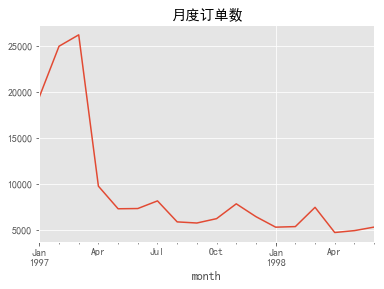

In [7]:
df.groupby("month").order_quantity.sum().plot(title="月度订单数")

1997年1-3月间月订单数在20000左右，3月后约在5000 - 8000间波动下滑。

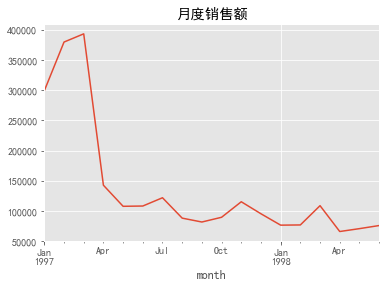

In [8]:
df.groupby("month").order_sum.sum().plot(title="月度销售额")

1997年1-3月间月消费人数在350000左右，3月后约在100000上下波动下滑。

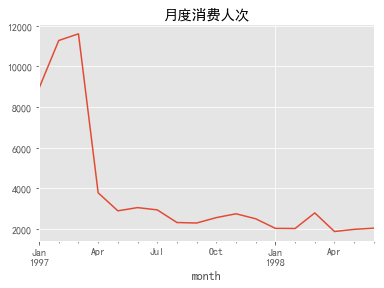

In [9]:
df.groupby("month").user_id.count().plot(title="月度消费人次")

1997年1-3月间月消费人次在10000左右，3月后约在2000 - 4000间波动下滑。

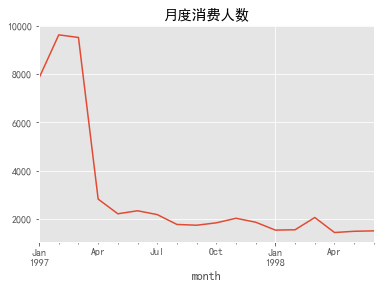

In [10]:
# 方法一：
df.groupby("month").user_id.nunique().plot(title = "月度消费人数")
# 方法二：
# u_d = df.groupby("month").user_id.apply(lambda x:len(x.drop_duplicates()))

1997年1-3月间月消费人数(去重)在8000 - 10000之间，3月后约在2000上下波动下滑。
总体而言，月消费人数小于月消费人次，但区别不大。

In [11]:
df.pivot_table(index="month",
              values=["order_quantity", "order_sum", "user_id"],
              aggfunc={"order_quantity":np.sum, "order_sum":np.sum, "user_id":"count"})

,order_quantity,order_sum,user_id
month,,,
1997-01,19416,299060.17,8928
1997-02,24921,379590.03,11272
1997-03,26159,393155.27,11598
1997-04,9729,142824.49,3781
1997-05,7275,107933.30,2895
1997-06,7301,108395.87,3054
1997-07,8131,122078.88,2942
1997-08,5851,88367.69,2320
1997-09,5729,81948.80,2296


## 第三部分：用户个体消费数据分析
- 用户消费金额和消费次数的描述统计
- 用户消费金额和消费次数的散点图
- 用户消费金额的分布图（二八法则）
- 用户消费次数的分布图
- 用户累计消费金额的占比（百分之多少的用户占了百分之多少的消费额）

In [12]:
# 按用户分组
grouped_user_raw = df.groupby("user_id")
grouped_user = grouped_user_raw.sum()
display(grouped_user.describe())

,order_quantity,order_sum
count,23570.000000,23570.000000
mean,7.122656,106.080426
std,16.983531,240.925195
min,1.000000,0.000000
25%,1.000000,19.970000
50%,3.000000,43.395000
75%,7.000000,106.475000
max,1033.000000,13990.930000


用户平均购买7张CD，最多一人购买了1033张。
用户平均消费金额与消费金额中位数接近，约为106，而标准差较大为241，显示存在小部分高额消费用户。

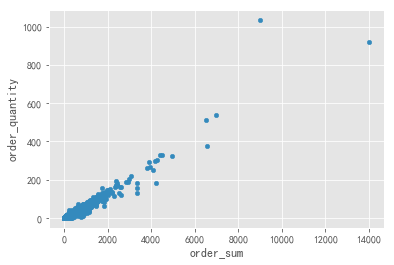

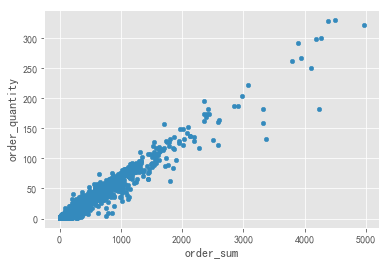

In [13]:
display(grouped_user.plot.scatter(x="order_sum", y="order_quantity"))
# 方法一：
# display(grouped_user.query("order_sum<6000").plot.scatter(x="order_sum", y="order_quantity"))
# 方法儿：
display(grouped_user[grouped_user["order_sum"] < 6000].plot.scatter(x="order_sum", y="order_quantity"))

用户比较健康且规律性强。因为商品比较单一，金额和商品量的关系也因此呈线性，离群点不多。

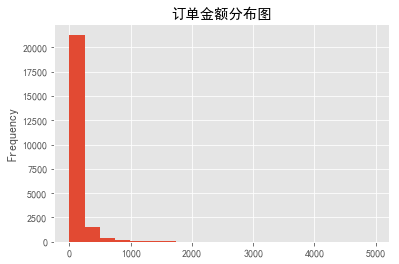

In [14]:
grouped_user.query("order_sum < 6000").order_sum.plot.hist(bins=20,title="订单金额分布图")

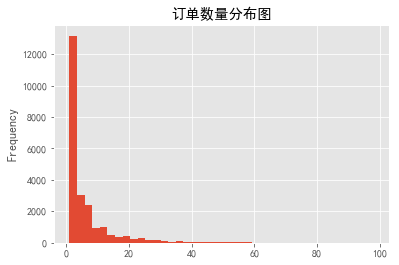

In [48]:
grouped_user.query("order_quantity < 100").order_quantity.plot.hist(bins=40,title="订单数量分布图")

从上图直方图可知，大部分用户的消费能力确实不高，绝大部分呈现集中在很低的消费档次。高消费用户在图上几乎看不到，符合消费行为的行业规律。
虽然有极致干扰了我们的数据，但是大部分的用户还是集中在比较低的而消费档次。

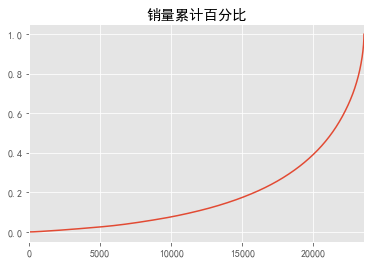

In [49]:
# 方法一：
# user_cumsum = grouped_user.sort_values("order_sum").cumsum() / grouped_user.order_sum.sum()
# 方法二：
user_cumsum = grouped_user.sort_values("order_sum").apply(lambda x: x.cumsum() / x.sum())
user_cumsum.reset_index().order_sum.plot(title="销量累计百分比")

按用户消费金额进行升序排序，由图可知50%的用户仅贡献了15%的销售额度。而排名前5000的用户就贡献了60%的消费额。

## 第四部分：用户消费行为分析
- 用户第一次消费（首购）。
- 用户最后一次消费
- 新老客消费比
    - 多少用户仅消费了一次
    - 每月新客占比
- 用户分层
    - RFM
    - 新、老、活跃、流失
- 用户购买周期（按订单）
    - 用户消费周期描述
    - 用户消费周期分布
- 用户生命周期（按第一次&最后一次消费）
    - 用户生命周期描述
    - 用户生命周期分布

### 用户初次消费和最后一次消费时间

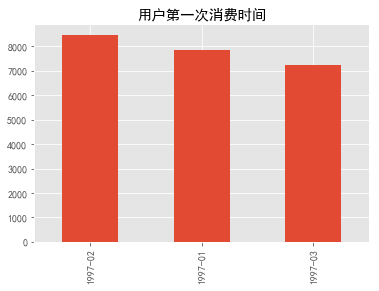

In [50]:
grouped_user_raw.month.min().value_counts().plot.bar(title="用户第一次消费时间")

统计用户第一次消费月份，图中可看出，用户第一次消费全部集中于前三月，且逐月递减。

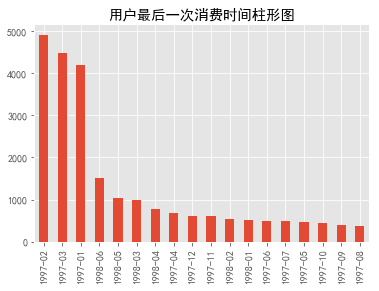

In [53]:
grouped_user_raw.month.max().value_counts().plot.bar(title="用户最后一次消费时间柱形图")

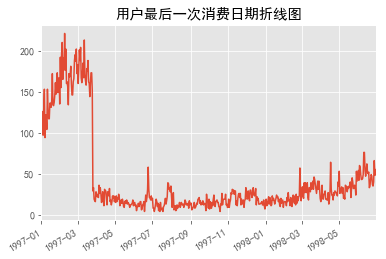

In [52]:
grouped_user_raw.order_dt.max().value_counts().plot(title="用户最后一次消费日期折线图")

- 统计用户最后一次消费时间。大部分用户最后一次消费集中在前三月，说明很多用户购买一次就不再购买。
- 随着时间增长，最后一次购买的用户数也在增加，说明用户流失上升，忠诚度下降。

### 仅消费一次占比

In [20]:
user_life = grouped_user_raw.order_dt.agg(["min", "max"])
user_life.head()

,min,max
user_id,,
1,1997-01-01,1997-01-01
2,1997-01-12,1997-01-12
3,1997-01-02,1998-05-28
4,1997-01-01,1997-12-12
5,1997-01-01,1998-01-03


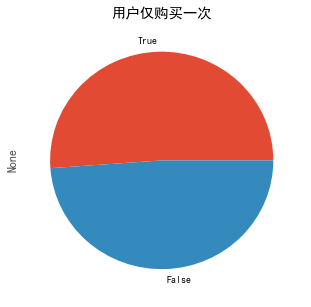

In [21]:
consume_once = (user_life["min"] == user_life["max"]).value_counts()
consume_once.plot.pie(figsize=(5,5),title="用户仅购买一次")

有约一半用户仅消费一次。

### RFM建模

In [22]:
rfm = df.pivot_table(index="user_id",
               values=["order_quantity", "order_sum", "order_dt"],
               aggfunc={"order_dt":"max", "order_sum":"sum", "order_quantity":"sum"})
rfm.head()

,order_dt,order_quantity,order_sum
user_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,6,89.00
3,1998-05-28,16,156.46
4,1997-12-12,7,100.50
5,1998-01-03,29,385.61


In [23]:
rfm["R"] = -(rfm.order_dt - rfm.order_dt.max()) / np.timedelta64(1,"D")
rfm.rename(columns={"order_quantity":"F", "order_sum":"M"}, inplace=True)
rfm.head()

,order_dt,F,M,R
user_id,,,,
1,1997-01-01,1,11.77,545.0
2,1997-01-12,6,89.00,534.0
3,1998-05-28,16,156.46,33.0
4,1997-12-12,7,100.50,200.0
5,1998-01-03,29,385.61,178.0


- R 表示用户最近一次消费时间据统计截止日的间隔，数值越小表示用户最近有活跃。
- F 表示用户统计时间段内的消费次数，数值越大表示消费越频繁。
- M 表示用户统计时间段内的消费金额，数值越大表示客户价值越高。

In [24]:
def rfm_level(x):
    level = x.apply(lambda x:"1" if x >= 0 else "0")
    label = level.R + level.F + level.M
    d = {
        '111':'重要价值客户',
        '011':'重要保持客户',
        '101':'重要挽留客户',
        '001':'重要发展客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般挽留客户',
        '000':'一般发展客户'
    }
    result = d[label]
    return result

rfm["label"] = rfm[["R", "F", "M"]].apply(lambda x: x - x.mean()).apply(rfm_level, axis=1)
rfm.head()

,order_dt,F,M,R,label
user_id,,,,,
1,1997-01-01,1,11.77,545.0,一般挽留客户
2,1997-01-12,6,89.00,534.0,一般挽留客户
3,1998-05-28,16,156.46,33.0,重要保持客户
4,1997-12-12,7,100.50,200.0,一般发展客户
5,1998-01-03,29,385.61,178.0,重要保持客户


In [25]:
rfm.groupby("label").sum().sort_values("F", ascending=False)

,F,M,R
label,,,
重要保持客户,107789,1592039.62,517267.0
一般挽留客户,29346,438291.81,6951815.0
一般发展客户,13977,196971.23,591108.0
重要价值客户,11121,167080.83,358363.0
重要发展客户,2023,45785.01,56636.0
一般保持客户,1712,19937.45,29448.0
重要挽留客户,1263,33028.40,114482.0
一般价值客户,650,7181.28,36295.0


不同层次客户RFM值，重要保持客户消费总金额最高，达159万，消费总次数最高，近11万次。

In [26]:
rfm.groupby("label").count().sort_values("F", ascending=False)

,order_dt,F,M,R
label,,,,
一般挽留客户,14074,14074,14074,14074
重要保持客户,4554,4554,4554,4554
一般发展客户,3300,3300,3300,3300
重要价值客户,787,787,787,787
重要发展客户,331,331,331,331
重要挽留客户,241,241,241,241
一般保持客户,206,206,206,206
一般价值客户,77,77,77,77


不同层次客户数量，消费金额和消费次数最高的重要保持客户排第二，人数4554人，较排第一的一般挽留客户有较大差距。

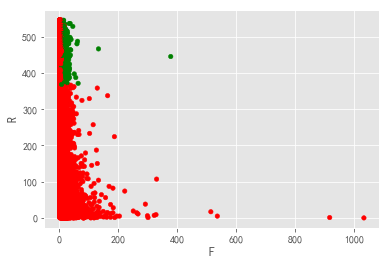

In [27]:
rfm.loc[rfm.label == "重要价值客户", "color"] = "g"
rfm.loc[~(rfm.label == "重要价值客户"), "color"] = "r"
rfm.plot.scatter("F", "R", c=rfm.color)

### 用户生命周期计算

In [28]:
pivot_counts = df.pivot_table(index="user_id",
                              columns="month",
                              values="order_dt",
                             aggfunc="count").fillna(0)
pivot_counts.head()

month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df_purchase = pivot_counts.applymap(lambda x: 1 if x > 0 else 0)
df_purchase.head()

month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


数据标准化，只统计每月是否消费，月消费大于0的，全部替换为1。

In [30]:
df_purchase.tail()

month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
23566,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23567,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23568,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23569,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23570,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


三月份注册的用户，未消费，因此需要进一步精细分类为：未注册、不活跃、回流、活跃用户。

In [31]:
def active_status(data):
    status = []
    for i in range(len(df_purchase.columns)):
        
        #若本月没有消费
        if data[i] == 0:
            if len(status) > 0:
                if status[i-1] == 'unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')
                    
        #若本月消费
        else:
            if len(status) == 0:
                status.append('new')
            else:
                if status[i-1] == 'unactive':
                    status.append('return')
                elif status[i-1] == 'unreg':
                    status.append('new')
                else:
                    status.append('active')
    data.iloc[:] = status
    return data

pivot_status= df_purchase.apply(active_status, axis = 1)
pivot_status.head()

month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


In [32]:
purchase_status_ct = pivot_status.replace("unreg", np.NaN).apply(lambda x: pd.value_counts(x))
purchase_status_ct

month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
active,NaN,1157.0,1681,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624.0,632.0,512.0,472.0,571.0,518.0,459.0,446.0
new,7846.0,8476.0,7248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1404.0,1232.0,1025.0,1079.0,1489.0,919.0,1029.0,1060.0
unactive,NaN,6689.0,14046,20748.0,21356.0,21231.0,21390.0,21798.0,21831.0,21731.0,21542.0,21706.0,22033.0,22019.0,21510.0,22133.0,22082.0,22064.0


In [33]:
purchase_status_ct.fillna(0).T

,active,new,return,unactive
month,,,,
1997-01,0.0,7846.0,0.0,0.0
1997-02,1157.0,8476.0,0.0,6689.0
1997-03,1681.0,7248.0,595.0,14046.0
1997-04,1773.0,0.0,1049.0,20748.0
1997-05,852.0,0.0,1362.0,21356.0
1997-06,747.0,0.0,1592.0,21231.0
1997-07,746.0,0.0,1434.0,21390.0
1997-08,604.0,0.0,1168.0,21798.0
1997-09,528.0,0.0,1211.0,21831.0


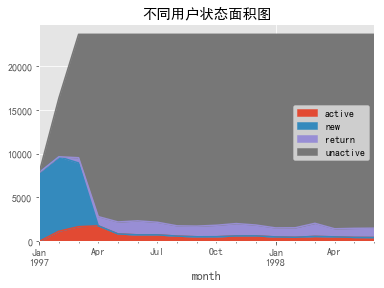

In [54]:
purchase_status_ct.fillna(0).T.plot.area(title="不同用户状态面积图")

In [35]:
purchase_status_ct.fillna(0).T.apply(lambda x: x / x.sum(), axis = 1)

,active,new,return,unactive
month,,,,
1997-01,0.000000,1.000000,0.000000,0.000000
1997-02,0.070886,0.519299,0.000000,0.409815
1997-03,0.071319,0.307510,0.025244,0.595927
1997-04,0.075223,0.000000,0.044506,0.880272
1997-05,0.036148,0.000000,0.057785,0.906067
1997-06,0.031693,0.000000,0.067543,0.900764
1997-07,0.031650,0.000000,0.060840,0.907510
1997-08,0.025626,0.000000,0.049555,0.924820
1997-09,0.022401,0.000000,0.051379,0.926220


- 活跃用户、持续消费的用户对应的是消费运营质量。回流用户，之前不消费本月才消费对应的是唤回运营。不活跃的用户对应的是流失
- 流失用户在增加，回流用户在减少。

### 用户购买周期

In [36]:
order_period = grouped_user_raw.apply(lambda x: x.order_dt - x.order_dt.shift())
order_period.head(10)

user_id   
1        0        NaT
2        1        NaT
         2     0 days
3        3        NaT
         4    87 days
         5     3 days
         6   227 days
         7    10 days
         8   184 days
4        9        NaT
Name: order_dt, dtype: timedelta64[ns]

In [37]:
order_period.describe()

count                      46089
mean     68 days 23:22:13.567662
std      91 days 00:47:33.924168
min              0 days 00:00:00
25%             10 days 00:00:00
50%             31 days 00:00:00
75%             89 days 00:00:00
max            533 days 00:00:00
Name: order_dt, dtype: object

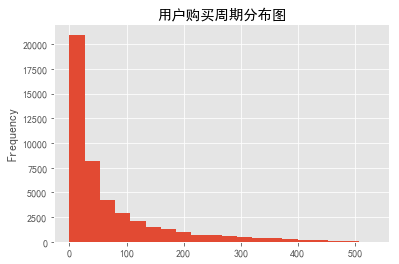

In [57]:
(order_period / np.timedelta64(1,"D")).plot.hist(bins=20,title="用户购买周期分布图")

订单周期呈右偏分布，用户平均购买周期为68天，绝大部分用户购买周期低于100天。

### 用户生命周期

In [39]:
(user_life["max"] - user_life["min"]).describe()

count                       23570
mean     134 days 20:55:36.987696
std      180 days 13:46:43.039788
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%             294 days 00:00:00
max             544 days 00:00:00
dtype: object

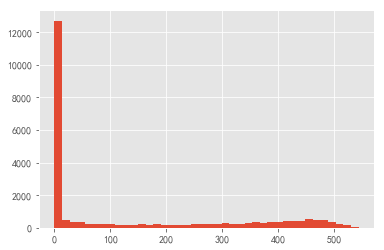

In [40]:
((user_life["max"] - user_life["min"]) / np.timedelta64(1,"D")).hist(bins=40)

- 数据偏移比较大，中位数为0，表示50%以上的用户只购买了一次。
- 平均生命周期为134天，最大值为544天。

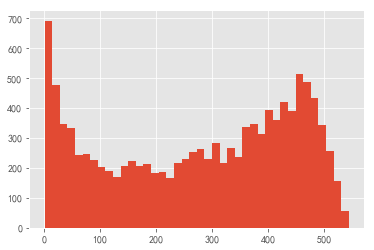

In [41]:
user_life_array = (user_life["max"] - user_life["min"]) / np.timedelta64(1,"D")
user_life_array[user_life_array > 0].hist(bins=40)

- 排除仅消费一次的用户，相当一部分用户生命周期在0天附近，部分用户虽然消费两次，但仍然无法持续。  
- 在用户首次消费30天内，应尽量引导。
- 少部分用户生命周期在50-300天，属于普通型生命周期。
- 高质量用户的生命周期，集中在400天以上，属于忠诚用户。

### 复购率

In [42]:
purchase_r = pivot_counts.applymap(lambda x: 1 if x > 1 else np.NaN if x == 0 else 0)
purchase_r.head()

month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


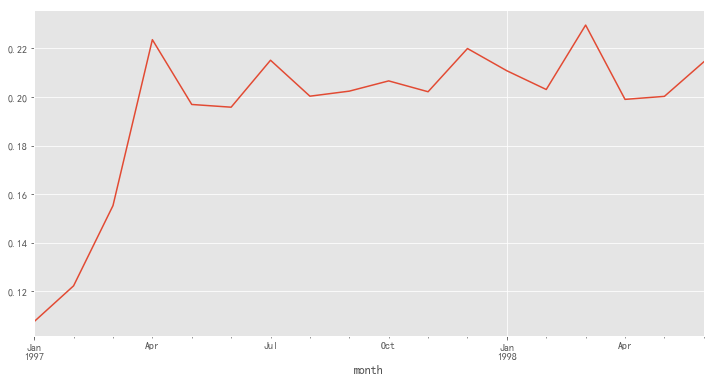

In [43]:
(purchase_r.sum()/purchase_r.count()).plot(figsize = (12,6))

- 初期新用户大量增加，复购率在6%左右。
- 后期新用户停止增长，复购率稳定在20%左右。

### 回购率

In [44]:
pivoted_amount = df.pivot_table(index = 'user_id',columns = 'month',values = 'order_quantity',aggfunc = 'mean').fillna(0)
columns_month = df.month.sort_values().astype('str').unique()
pivoted_amount.columns = columns_month
pivoted_amount.head()

,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.5,3.0,0.0,3.0,3.0,2.0,2.0,0.0,3.0,0.0,0.0,3.5,3.0,0.0,0.0,0.0,0.0,0.0


In [45]:
pivoted_purchase = pivoted_amount.applymap(lambda x: 1 if x>0 else 0)
pivoted_purchase.head()

,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [46]:
def purchase_return(data):
    status = []
    for i in range(17):
        if data[i] == 1:
            if data[i+1] ==1:
                status.append(1)
            if data[i+1] == 0:
                status.append(0)
        else:
            status.append(np.NaN)
    status.append(np.NaN)
    data[:] = status
    return data
pivoted_purchase_return = pivoted_purchase.apply(purchase_return,axis = 1)
pivoted_purchase_return.head(5)

,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


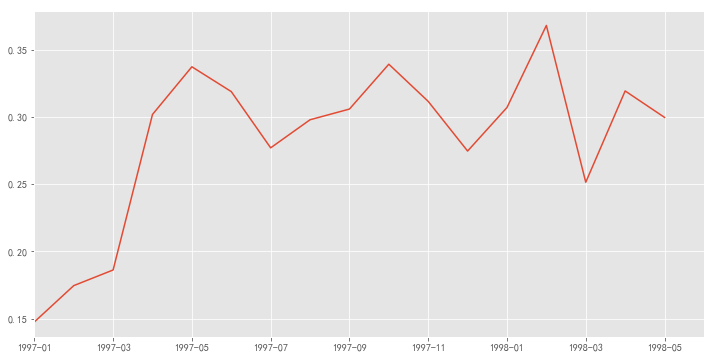

In [47]:
(pivoted_purchase_return.sum() / pivoted_purchase_return.count()).plot(figsize = (12,6))

- 用户回购率大于复购率，在维持稳定后，回购率在30%上下波动。
